In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

# Configuration for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
pd.set_option('display.max_columns', None)

# Load the data
df = pd.read_csv('train.csv')
print(f"Dataset Loaded: {df.shape[0]} rows, {df.shape[1]} columns.")

Dataset Loaded: 44553 rows, 27 columns.


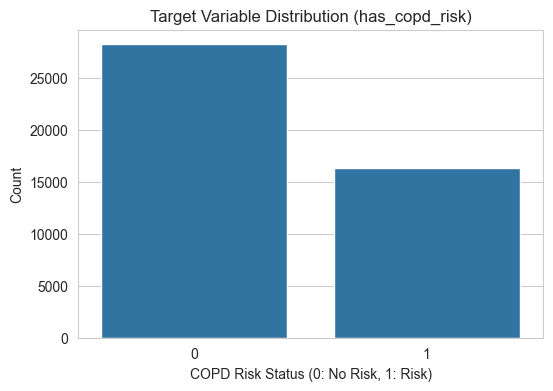


Risk Ratio:
has_copd_risk
0    63.32
1    36.68
Name: proportion, dtype: float64


In [12]:
# CODE BLOCK 1: Target Distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='has_copd_risk', data=df)
plt.title('Target Variable Distribution (has_copd_risk)')
plt.xlabel('COPD Risk Status (0: No Risk, 1: Risk)')
plt.ylabel('Count')
plt.show()

# Print exact ratios for parameter guidance
print("\nRisk Ratio:")
print(df['has_copd_risk'].value_counts(normalize=True).round(4) * 100)

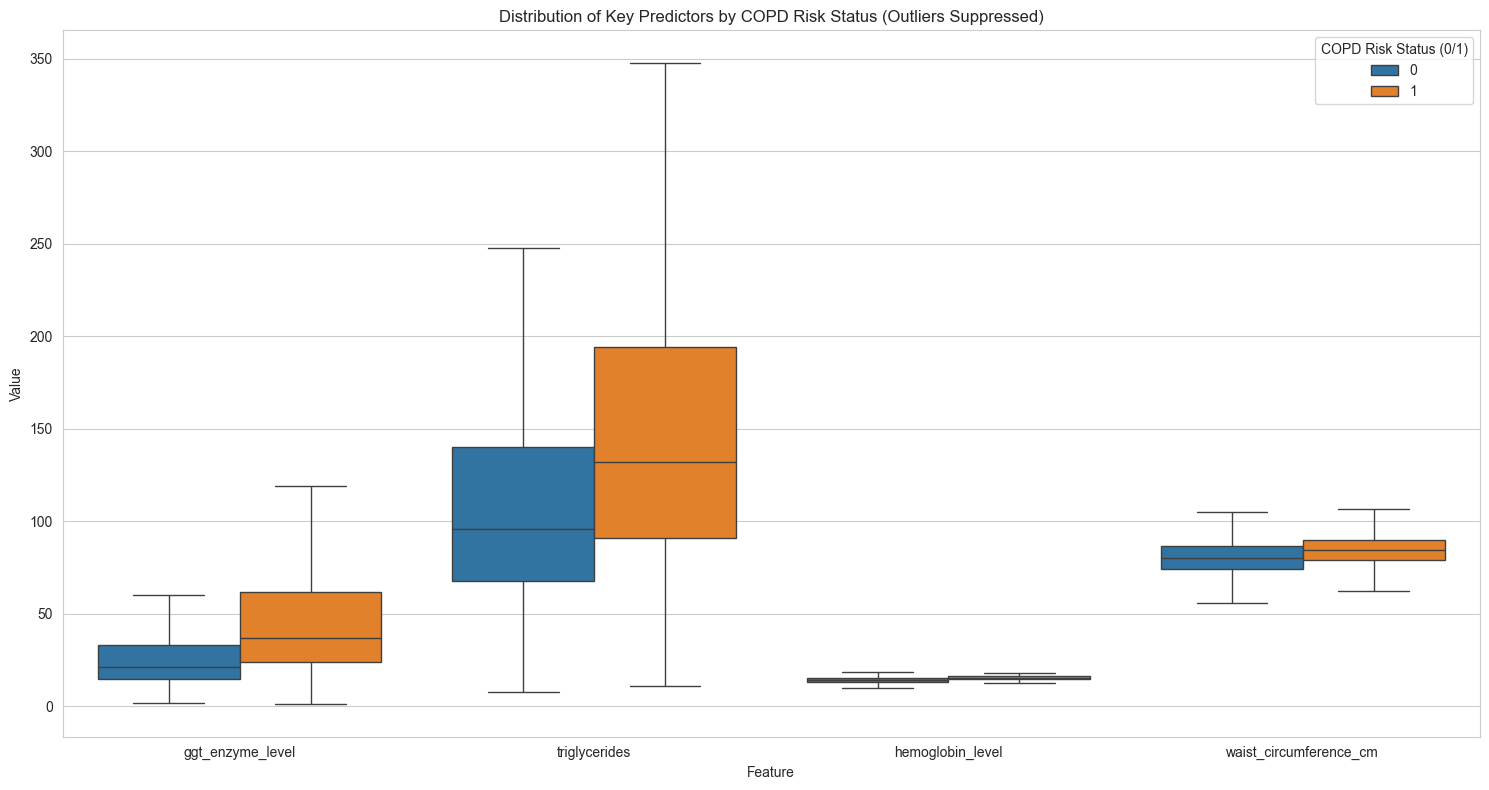

In [13]:
# CODE BLOCK 1: Box Plots of Key Predictors vs. Risk
key_cols = ['ggt_enzyme_level', 'triglycerides', 'hemoglobin_level', 'waist_circumference_cm']

# Melt the DataFrame for easy plotting with seaborn
plot_data = df.melt(id_vars='has_copd_risk', 
                    value_vars=key_cols, 
                    var_name='Feature', 
                    value_name='Value')

plt.figure(figsize=(15, 8))
# showfliers=False is used to focus the plot on the central tendency difference, ignoring extreme outliers
sns.boxplot(x='Feature', y='Value', hue='has_copd_risk', data=plot_data, showfliers=False)
plt.title('Distribution of Key Predictors by COPD Risk Status (Outliers Suppressed)')
plt.ylabel('Value')
plt.xlabel('Feature')
plt.legend(title='COPD Risk Status (0/1)')
plt.tight_layout()
plt.show()

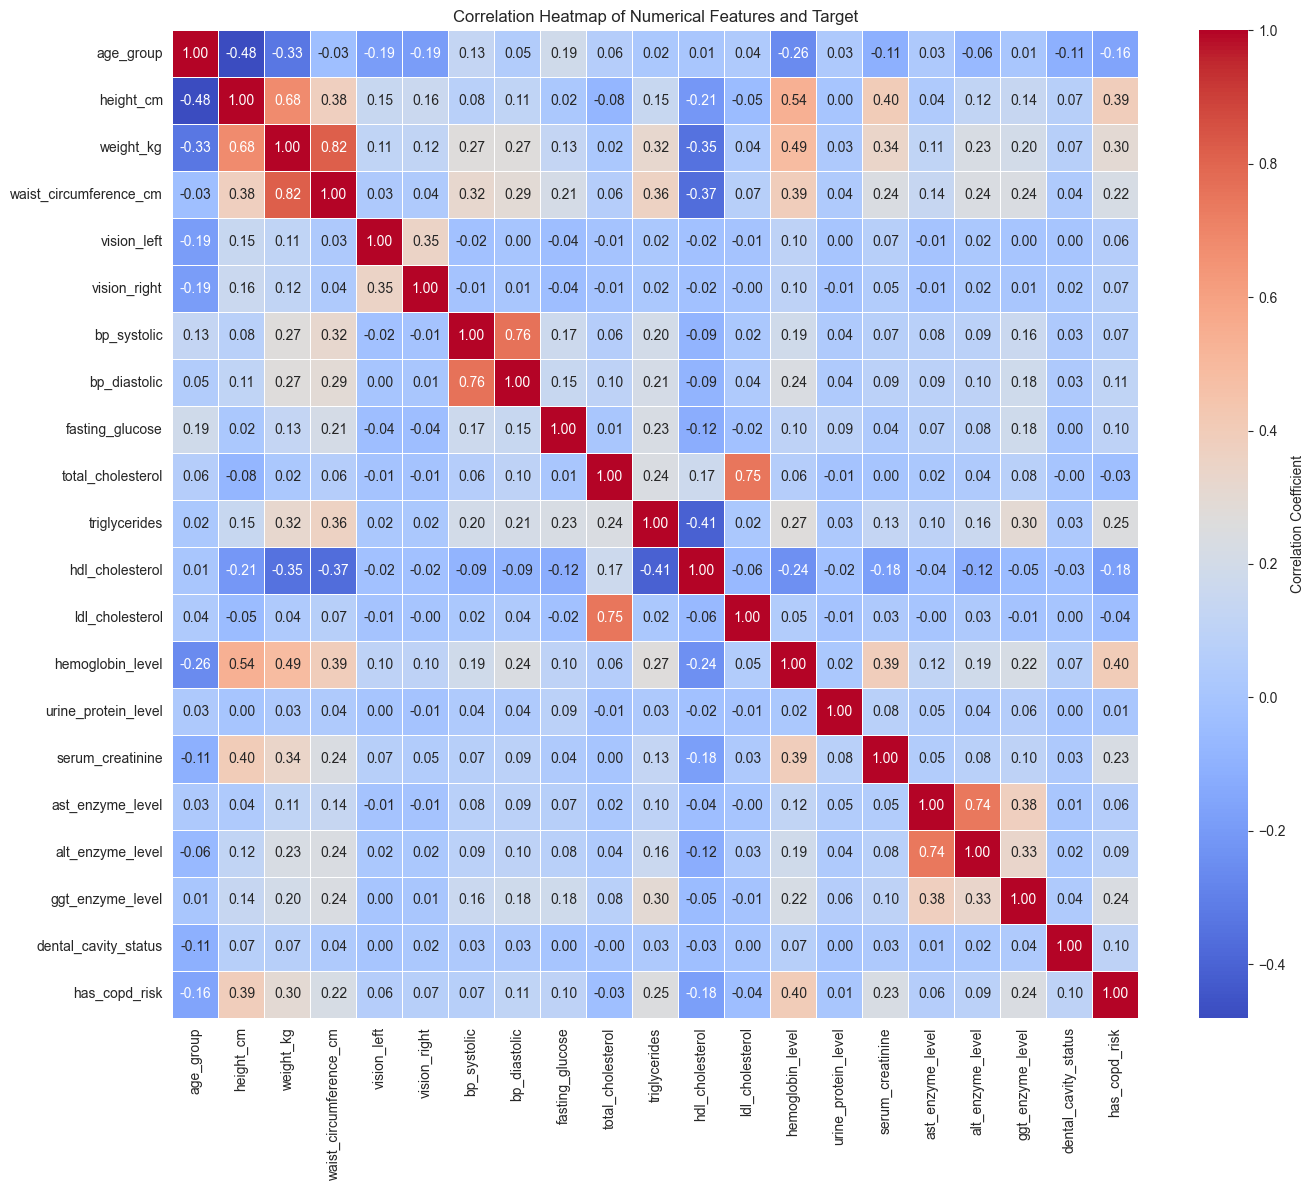

In [14]:
# CODE BLOCK 2: Correlation Heatmap
# Identify numerical and binary-encoded features for correlation analysis
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Include the target variable and exclude patient ID
corr_cols = [col for col in numerical_cols if col not in ['patient_id', 'hearing_left', 'hearing_right']]

corr_matrix = df[corr_cols].corr().round(2)

plt.figure(figsize=(14, 12))
# Use 'annot=True' here to show the numerical correlation values
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=.5, 
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Heatmap of Numerical Features and Target')
plt.tight_layout()
plt.show()

# Guidance from Correlation:
# - Look at the last column ('has_copd_risk'). The features with the highest absolute correlation 
#   (e.g., ggt_enzyme_level, triglycerides) are the best linear predictors.
# - Look for high correlation (>= 0.8) between two predictor features (Multicollinearity).
#   If found, use L1 Regularization (Lasso) in Logistic Regression or drop one feature.

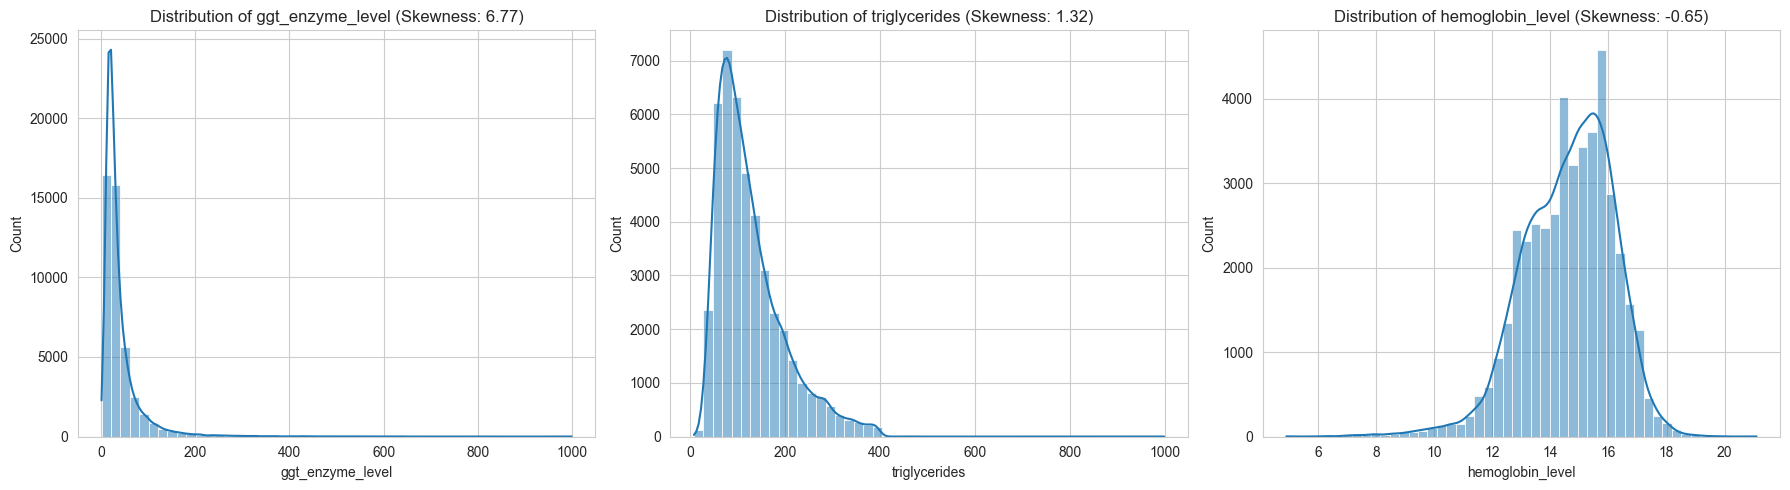

In [15]:
# CODE BLOCK 3: Histograms of Top Predictors
top_predictors = ['ggt_enzyme_level', 'triglycerides', 'hemoglobin_level']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(top_predictors):
    sns.histplot(df[col], kde=True, ax=axes[i], bins=50)
    axes[i].set_title(f'Distribution of {col} (Skewness: {df[col].skew():.2f})')
    
plt.tight_layout()
plt.show()

# Guidance from Distribution:
# - ggt_enzyme_level and triglycerides are highly right-skewed and have outliers.
# - Use Log-Transformation (np.log1p(df[col])) on these for linear models (Logistic Regression, SVM, NN).
# - Use StandardScaler or MinMaxScaler on ALL numerical features for NN and SVM.

In [16]:
# CODE BLOCK 4: Age Group x Sex Interaction (Altair Plot)
# Recalculate the mean risk rate for each Age/Sex combination
interaction_data = df.groupby(['age_group', 'sex'])['has_copd_risk'].mean().reset_index()
interaction_data['Risk Rate (%)'] = (interaction_data['has_copd_risk'] * 100).round(2)
interaction_data['age_group'] = interaction_data['age_group'].astype(str) # For categorical x-axis

chart = alt.Chart(interaction_data).mark_bar().encode(
    x=alt.X('age_group:N', title='Age Group', sort=interaction_data['age_group'].unique().tolist()),
    y=alt.Y('Risk Rate (%):Q', title='COPD Risk Rate (%)'),
    color=alt.Color('sex:N', title='Sex'),
    tooltip=['age_group', 'sex', 'Risk Rate (%)']
).properties(
    title='COPD Risk Rate by Age Group and Sex Interaction (Highest Risk in Young Males)'
).interactive() 

# To display the interactive plot in your notebook:
chart

alt.Chart(...)

In [24]:
# === NEW FEATURES ===
df = df.copy()

# 1. BMI (huge COPD risk factor)
df['bmi'] = df['weight_kg'] / ((df['height_cm']/100)**2)

# 2. Obesity classes
df['obesity_class'] = pd.cut(df['bmi'], 
                            bins=[0, 18.5, 25, 30, 35, 40, 100], 
                            labels=['Underweight', 'Normal', 'Overweight', 'Obese I', 'Obese II', 'Obese III'])

# 3. Waist-to-height ratio (better than waist alone)
df['whr'] = df['waist_circumference_cm'] / df['height_cm']

# 4. Blood pressure categories
def bp_category(row):
    if row['bp_systolic'] < 120 and row['bp_diastolic'] < 80:
        return 'Normal'
    elif row['bp_systolic'] < 130 and row['bp_diastolic'] < 80:
        return 'Elevated'
    elif row['bp_systolic'] < 140 or row['bp_diastolic'] < 90:
        return 'HTN Stage 1'
    else:
        return 'HTN Stage 2'
df['bp_category'] = df.apply(bp_category, axis=1)

# 5. Lipid ratios (much stronger predictors than raw values)
df['total_chol_hdl_ratio'] = df['total_cholesterol'] / df['hdl_cholesterol']
df['triglycerides_hdl_ratio'] = df['triglycerides'] / df['hdl_cholesterol']
df['ldl_hdl_ratio'] = df['ldl_cholesterol'] / df['hdl_cholesterol']

# 6. Liver enzyme elevation flags
liver_enzymes = ['ast_enzyme_level', 'alt_enzyme_level', 'ggt_enzyme_level']
for col in liver_enzymes:
    df[f'{col}_elevated'] = (df[col] > df[col].quantile(0.95)).astype(int)

# 7. Age as numeric for correlation
df['age_numeric'] = df['age_group'].astype(int)

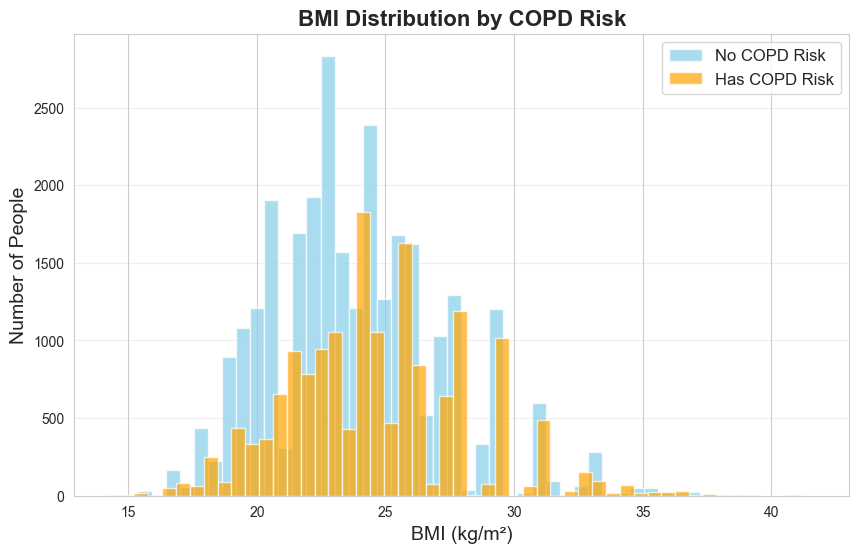

In [28]:
plt.figure(figsize=(10, 6))

# Two histograms on the same plot
plt.hist(df[df['has_copd_risk'] == 0]['bmi'], bins=50, alpha=0.7, label='No COPD Risk', color='skyblue')
plt.hist(df[df['has_copd_risk'] == 1]['bmi'], bins=50, alpha=0.7, label='Has COPD Risk', color='orange')

plt.xlabel('BMI (kg/m²)', fontsize=14)
plt.ylabel('Number of People', fontsize=14)
plt.title('BMI Distribution by COPD Risk', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()